# Malaria Diagnosis CNN (Binary Classification)

In [201]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC

from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.regularizers import L2

import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

### Data Preparation

In [202]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]']
    )
full_dataset = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
)

print(full_dataset)

({'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}, tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/vardaangrover/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
 

In [203]:
# Our own custom split function
def split_data(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    train_ds = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_ds = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE)).take(int(VAL_RATIO * DATASET_SIZE))
    test_ds = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
    return train_ds, val_ds, test_ds

In [204]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
TOTAL = 10

train_ds, val_ds, test_ds = split_data(full_dataset[0]['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [205]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [206]:
train_dataset = dataset[0]
val_dataset = dataset[1]
test_dataset = dataset[2]

In [207]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2756
2756


In [208]:
for i in val_dataset.take(1):
    print(i)

{'image': <tf.Tensor: shape=(232, 229, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


2025-01-28 17:23:49.751446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Data Visualization

In [209]:
def get_label_str(label):
    if (label == 0):
        return 'Parasitized'
    else:
        return 'Uninfected'

2025-01-28 17:23:49.831251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


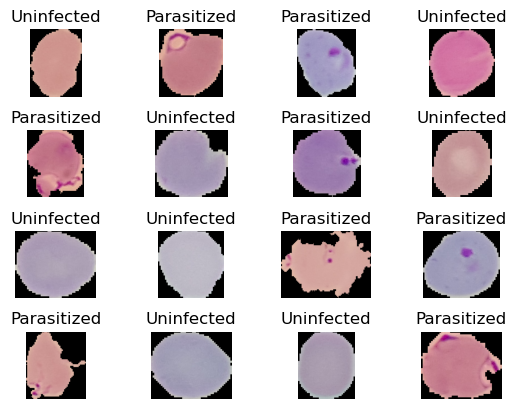

In [210]:
for i, sample in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(sample['image'])
    plt.title(get_label_str(sample['label'].numpy()))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

2025-01-28 17:23:49.974367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


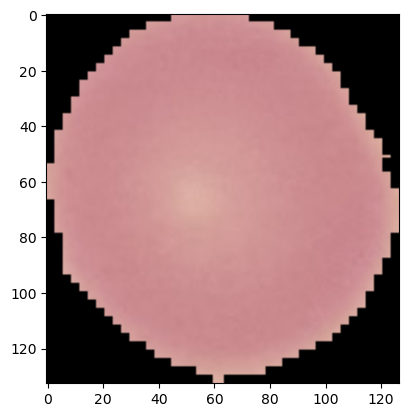

In [211]:
for i in train_dataset.take(2):
    plt.imshow(i['image'])

### Data Preprocessing

**Data Augmentation**

In [212]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)
    plt.title('Augmented Image')
    plt.axis('off')
    
    plt.show()

In [213]:
original_image, label = next(iter(train_ds))['image'], next(iter(train_ds))['label']

In [214]:
print(original_image.shape)
print(label.numpy())

(145, 148, 3)
1


In [215]:
augmented_image = tf.image.central_crop(original_image, central_fraction=0.8)
print(augmented_image.shape)

(117, 120, 3)


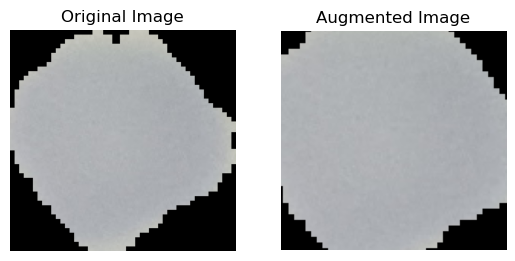

In [216]:
visualize(original_image, augmented_image)

### Data Processing

In [217]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [218]:
def resize_rescale(inputs):
    return tf.image.resize(inputs['image'], (IMG_SIZE, IMG_SIZE))/255, inputs['label']

In [219]:
# tf.image Augmentation
def augment(inputs):
    image, label = resize_rescale(inputs)
    
    image = tf.image.rot90(image)
    image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)
    
    return image, label

In [220]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    def call(self, image):
        return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [221]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1.0/255),
])

In [222]:
# tf.keras.layers Augmentation
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal',),
])

def augment_layer(inputs):
    image, label = resize_rescale(inputs)
    return augment_layers(resize_rescale_layers(image), training=True), label

In [223]:
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-01-28 17:23:50.263419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


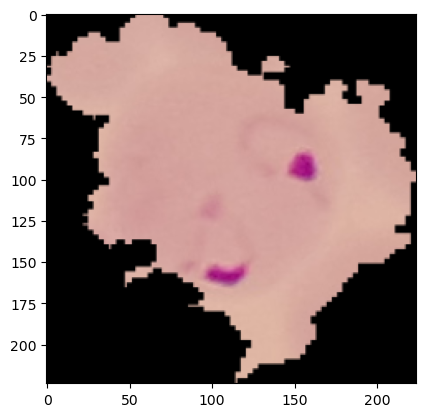

In [224]:
for i in train_dataset.take(9):
    # print(i[0][0])
    plt.imshow(i[0][28])

In [225]:
### When Keras expects a single tensor as the input, but the dataset generator returns a dictionary with keys like "image" and "label," the input structure doesn’t match what the model was built to accept. Keras sees something like {'image': Tensor(...), 'label': Tensor(...)} instead of just Tensor(...). The fix is to transform your dataset to output (image, label) pairs so the model receives only the images as input and the labels as targets.

# train_dataset = train_dataset.map(lambda x: (x['image'], x['label']))
# val_dataset = val_dataset.map(lambda x: (x['image'], x['label']))
# test_dataset = test_dataset.map(lambda x: (x['image'], x['label']))

In [226]:
for image, label in train_dataset.take(1): 
    print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

2025-01-28 17:23:50.389856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Mixup Data Augmentation

In [227]:
train_dataset_1 = train_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)
train_dataset_2 = train_ds.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [228]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2 

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    image = lamda * image_1 + (1-lamda) * image_2
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1-lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [229]:
# train_dataset = mixed_dataset.map(mixup).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [230]:
# train_dataset

### CutMix Data Augmentation

(-0.5, 223.5, 223.5, -0.5)

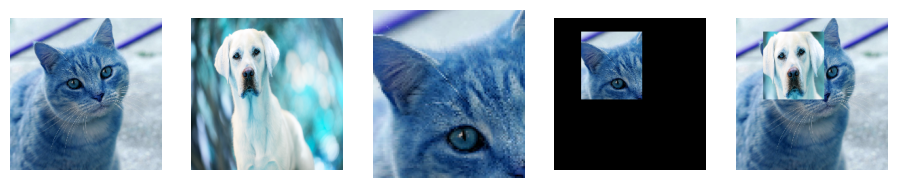

In [231]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 7, 1)
cat_image = cv2.resize(cv2.imread("cat.png"), (IMG_SIZE, IMG_SIZE))
plt.imshow(cat_image)
plt.axis('off')

plt.subplot(1, 7, 2)
dog_image = cv2.resize(cv2.imread("dog.png"), (IMG_SIZE, IMG_SIZE))
plt.imshow(dog_image)
plt.axis('off')

plt.subplot(1, 7, 3)
crop_cat = tf.image.crop_to_bounding_box(
    cat_image,
    offset_height=20,
    offset_width=40,
    target_height=100,
    target_width=90,
)
plt.imshow(crop_cat)
plt.axis('off')

plt.subplot(1, 7, 4)
crop_cat_padded_image = tf.image.pad_to_bounding_box(
    crop_cat,
    offset_height=20,
    offset_width=40,
    target_height=IMG_SIZE,
    target_width=IMG_SIZE,
)
plt.imshow(crop_cat_padded_image)
plt.axis('off')

crop_dog = tf.image.crop_to_bounding_box(
    dog_image,
    offset_height=20,
    offset_width=40,
    target_height=100,
    target_width=90,
)

crop_dog_padded_image = tf.image.pad_to_bounding_box(
    crop_dog,
    offset_height=20,
    offset_width=40,
    target_height=IMG_SIZE,
    target_width=IMG_SIZE,
)

plt.subplot(1, 7, 5)
plt.imshow(cat_image - crop_cat_padded_image + crop_dog_padded_image)
plt.axis('off')

In [232]:
def box(lamda):
    rx = tf.cast(tfp.distributions.Uniform(0, IMG_SIZE,).sample(1)[0], dtype=tf.int32)
    ry = tf.cast(tfp.distributions.Uniform(0, IMG_SIZE).sample(1)[0], dtype=tf.int32)

    rw = tf.cast(IMG_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    rh = tf.cast(IMG_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)


    rx = tf.clip_by_value(rx - rw//2, 0, IMG_SIZE)
    ry = tf.clip_by_value(ry - rh//2, 0, IMG_SIZE)

    xbr = tf.clip_by_value(rx + rw//2, 0, IMG_SIZE)
    ybr = tf.clip_by_value(ry + rh//2, 0, IMG_SIZE)

    rw = xbr - rx
    if (rw == 0):
        rw = 1
    rh = ybr - ry
    if (rh == 0):
        rh = 1

    return ry, rx, rh, rw

In [237]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2 
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    ry, rx, rh, rw = box(lamda)

    crop_2 = tf.image.crop_to_bounding_box(
        image_2,
        offset_height=ry,
        offset_width=rx,
        target_height=rh,
        target_width=rw,
    )
    pad_2 = tf.image.pad_to_bounding_box(
        crop_2,
        offset_height=ry,
        offset_width=rx,
        target_height=IMG_SIZE,
        target_width=IMG_SIZE,
    )
    
    crop_1 = tf.image.crop_to_bounding_box(
        image_1,
        offset_height=ry,
        offset_width=rx,
        target_height=rh,
        target_width=rw,
    )
    
    pad_1 = tf.image.pad_to_bounding_box(
        crop_1,
        offset_height=ry,
        offset_width=rx,
        target_height=IMG_SIZE,
        target_width=IMG_SIZE,
    )
    
    image = image_1 - pad_1 + pad_2
    lamda = tf.cast(1- (rh * rw)/(IMG_SIZE * IMG_SIZE), dtype=tf.float32)
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1-lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [238]:
train_dataset = mixed_dataset.map(cutmix).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [239]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

0.88183594


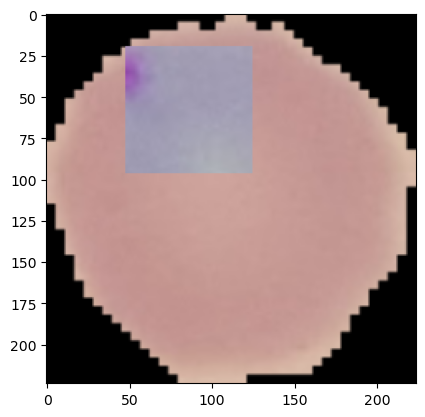

In [243]:
original_image, label = next(iter(train_dataset))
print(label[0].numpy())
plt.imshow(original_image[0])

### Model Creation (Functional API)

In [518]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    )(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
    
x = Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    )(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='feature_extractor')

feature_extractor_model.summary()

Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [519]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = feature_extractor_model(func_input)
    
x = Flatten()(x)
    
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

model = Model(func_input, func_output, name='functional_model')

model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor (Functional)  │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Subclassing

In [520]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size, strides=2 * strides)
        
        self.conv_2 = Conv2D(filters=filters * 2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size, strides=2 * strides)

    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)



In [521]:
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = feature_sub_classed(func_input)
    
x = Flatten()(x)
    
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

model = Model(func_input, func_output, name='functional_model')

model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor_8             │ (None, 54, 54, 16)     │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [522]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation='relu')
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        
        return x
    
lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]))
lenet_subclassed_model.summary()

Model: "lenet_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_9             │ ?                      │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (1, 46656)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (1, 100)               │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (1, 10)                │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (1, 10)                │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

### Custom Layers

In [523]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
    
    def build(self, input_features_shape):
        self.layer_weights = self.add_weight(shape=(input_features_shape[-1], self.output_units), trainable=True, initializer='random_normal')
        self.layer_biases = self.add_weight(shape=(self.output_units,), trainable=True, initializer='random_normal')
        
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.layer_weights) + self.layer_biases
        
        if (self.activation == 'relu'):
            return tf.nn.relu(pre_output)
        elif (self.activation == 'sigmoid'):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [524]:
model = tf.keras.Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    
    CustomDenseLayer(100, activation='relu'),
    BatchNormalization(),
    CustomDenseLayer(10, activation='relu'),
    BatchNormalization(),
    CustomDenseLayer(1, activation='sigmoid')
])

model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_12           │ (None, 100)            │     4,665,700 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_13           │ (None, 10)             │         1,010 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_14           │ (None, 1)              │            11 │
│ (CustomDenseLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Creation (Sequential API)

In [244]:
dropout_rate = 0.2
regularization_rate = 0.01

model = tf.keras.Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    augment_layers,
    
    Conv2D(
        filters=6, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu',
        kernel_regularizer=L2(0.01)
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Dropout(rate=0.2),
    
    Conv2D(
        filters=16, 
        kernel_size=3, 
        strides=1, 
        padding='valid',
        activation='relu',
        kernel_regularizer=L2(0.01),
    ),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    
    Dense(100, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    
    Dropout(rate=0.2),
    
    Dense(10, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Callbacks

In [245]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\nEpoch Number {epoch+1} the model has a loss of {logs['loss']}")
        
    # def on_batch_end(self, batch, logs):
    #     print(f"\Batch Number {batch+1} the model has a loss of {logs['loss']}")

In [246]:
csv_callback = CSVLogger(
    'logs.csv',
    separator=',',
    append=False
)

In [247]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [248]:
def scheduler(epoch, lr):
    if epoch < 3:
        return float("{:.8f}".format(lr))
    else:
        return float("{:.8f}".format(lr * tf.math.exp(-0.1)))

lr_scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [249]:
checkpoint_callback = ModelCheckpoint(
    './checkpoint_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1,
)

In [250]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
)

### Model Training

In [251]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy'), TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')],
)

In [252]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[
        csv_callback,
        es_callback,
        lr_scheduler_callback,
        checkpoint_callback,
        plateau_callback,
    ]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/10
 94/689 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.3166 - auc: 0.6079 - fn: 441.5425 - fp: 167.7021 - loss: 5.1441 - precision: 0.8111 - recall: 0.5997 - tn: 190.7234 - tp: 720.0319

KeyboardInterrupt: 

### Model Evaluation and Testing

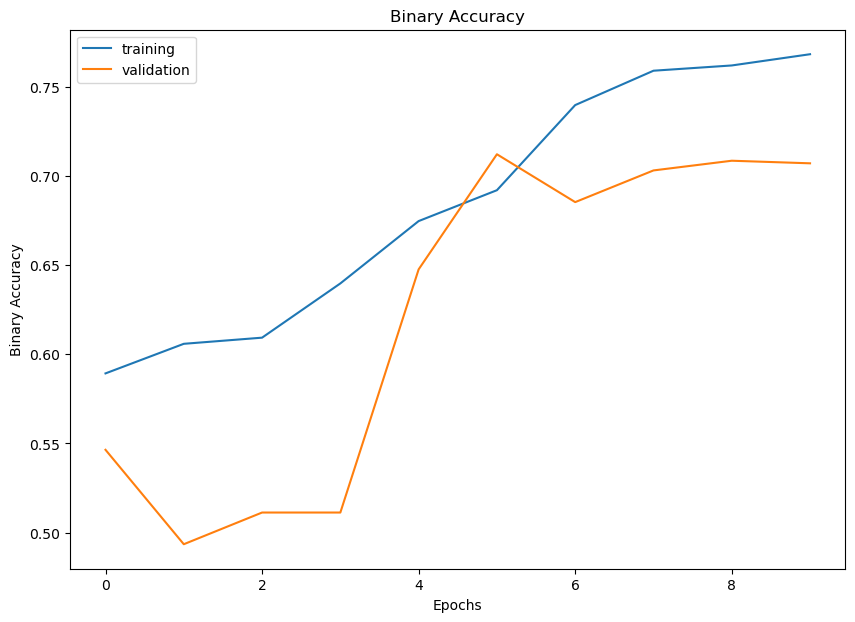

In [444]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Binary Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')

plt.legend(['training', 'validation'])

plt.show()

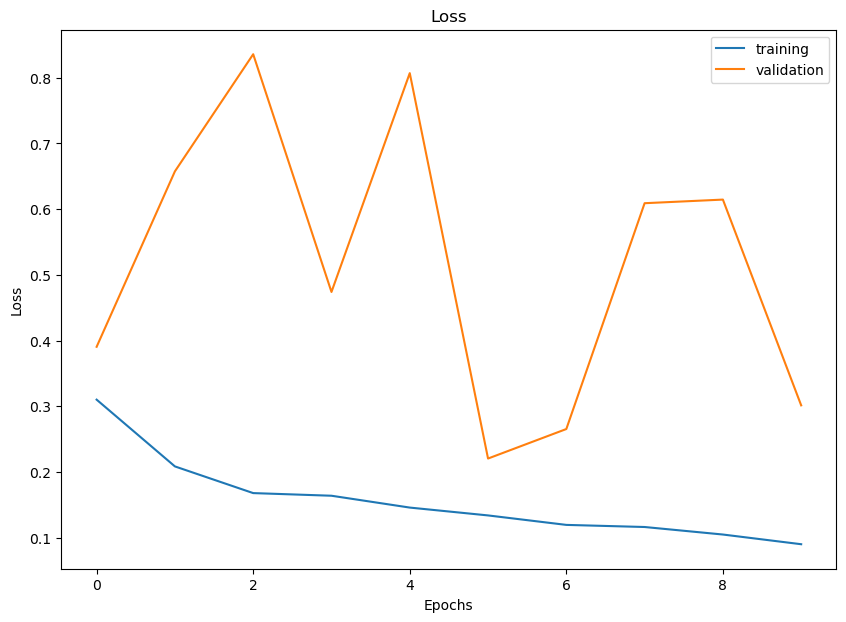

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['training', 'validation'])

plt.show()

In [445]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7390 - auc: 0.7956 - fn: 68.3977 - fp: 318.8068 - loss: 0.6637 - precision: 0.6782 - recall: 0.9057 - tn: 393.0114 - tp: 642.7841


[0.6690510511398315,
 0.7213352918624878,
 1251.0,
 634.0,
 737.0,
 134.0,
 0.66366046667099,
 0.9032490849494934,
 0.780439555644989]

In [446]:
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

In [447]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2025-01-14 00:53:20.155763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


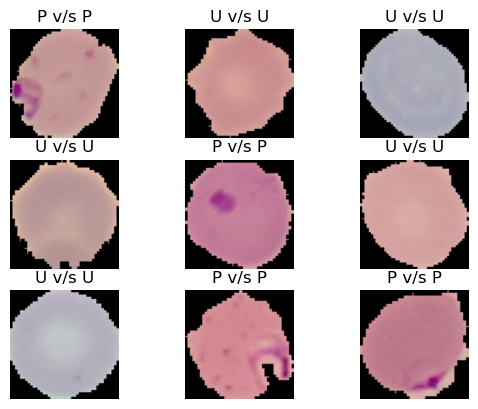

In [448]:
for image, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i])
        plt.title(parasite_or_not(label.numpy()[i]) + " v/s " + parasite_or_not(model.predict(image)[i][0]))
        plt.axis('off')

### Loading & Saving Model

In [449]:
model.save('LenetSavedModel.keras')

In [450]:
loaded_model = tf.keras.models.load_model('LenetSavedModel.keras')

loaded_model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,004,365 (53.42 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 9,336,068 (35.61 MB)

### Visualizing Confusion Matrix

In [451]:
labels = []
inputs = []

for i in test_ds.as_numpy_iterator():
    image, label = resize_rescale(i)
    labels.append(label)
    inputs.append(image)

2025-01-14 00:53:54.743240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [452]:
inputs = np.array(inputs)
print(inputs.shape)

(2755, 224, 224, 3)


In [453]:
labels = np.array(labels)
print(labels)

[1 0 1 ... 0 1 0]


In [454]:
predicted = loaded_model.predict(inputs)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [455]:
print(predicted.shape)

(2755, 1)


In [456]:
predicted = tf.squeeze(predicted)
print(predicted.shape)

(2755,)


In [457]:
predicted > 0.5

<tf.Tensor: shape=(2755,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

[[ 996  396]
 [ 347 1016]]


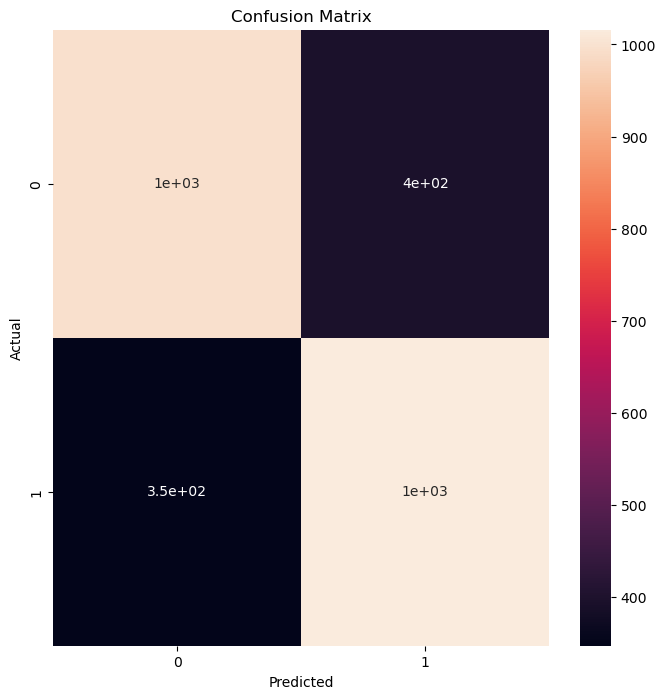

In [462]:
threshold = 0.56

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

### ROC Plots

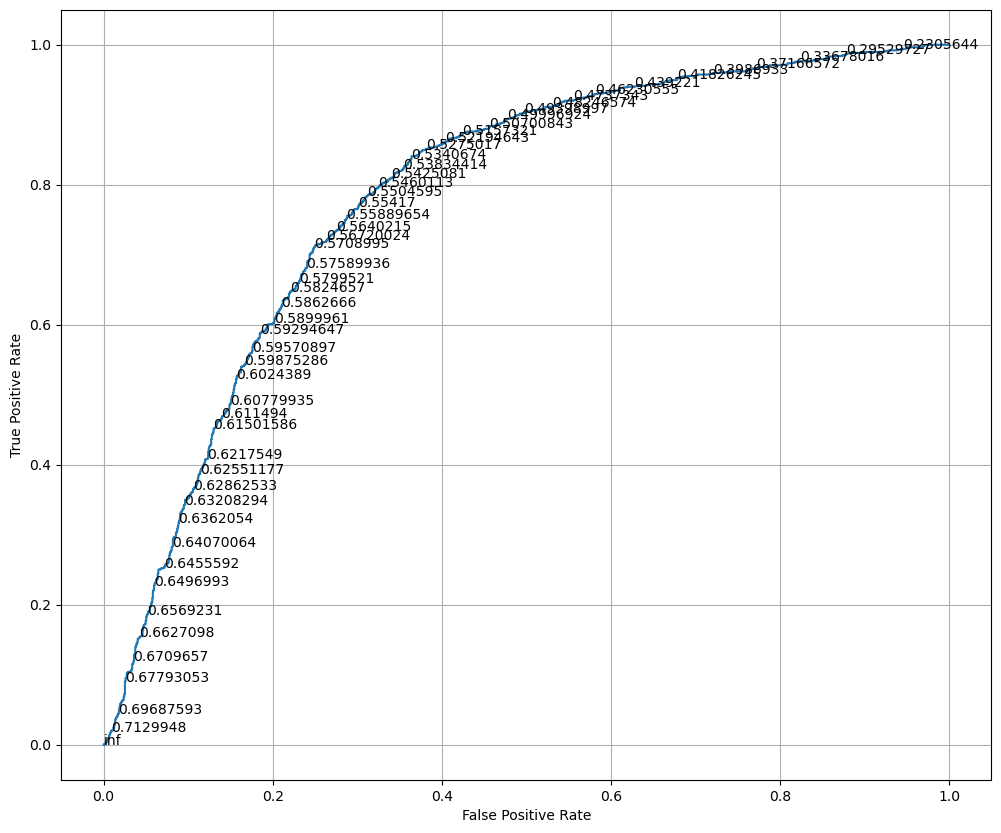

In [459]:
fp, tp, thresholds = roc_curve(labels, predicted)

plt.figure(figsize=(12, 10))

plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])

plt.show()